# Predicting Canadian provinces based on COVID-19 data
### Group Members
Jason Ji (69217222), Mikayla Chau (29043288), Linda Zhang (95711800), Alireza Mohammadi (20700985)

In [1]:
# loading the needed libraries
# setting seed for randomized operation to make the results reproducible
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 13)
set.seed(100)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

### Intoduction


COVID-19 is an infectious disease caused by the SARS-CoV-2 virus (Government of Canada). It was first identified on December 12th, 2019, and quickly spread across the globe (CDC Museum Covid-19 Timeline). Canada was also severely impacted by COVID-19 with nearly 4,300,000 infected people by the end of September, 2022. However, the number of infected is not spread evenly across the country due to massive population differences between the provinces.

With this model, we can predict which Canadian province best describes a given territorial health report, which has the total number of confirmed COVID-19 cases and the percent recovery rate of the province. In order to do so we will investigate public health information gathered from different Canadian provinces beginning in January 2020. 

The dataset was obtained from https://health-infobase.canada.ca/ (Health Info Base of the Government of Canada) based on data that provincial and territorial partners published on cases and deaths. This data contains daily information of COVID-19 cases from January 2020 until December 2021. Although there are 40 columns in the original dataset, we have chosen three to train our model:

1. province : Canadian province or territory from which the information was reported, containing names of 13 Canadian provinces and territories, with additional aggregated data for Canada as a whole and repatriated travellers.
2. numconf : Number of confirmed cases in each province (Canada = sum of all provinces/territories)
3. percentrecover : Percentage of recovered cases. Calculated by the number of recovered cases for each province/territory divided by the total number of confirmed cases for that province/territory

As of October 21, 2022, 9 am ET,Public Health Agency of Canada (PHAC) has received detailed case report data on 4,135,488 cases.






References:

Public Health Agency. “Government of Canada.” Canada.ca, Government of Canada, 18 Aug. 2022, https://www.canada.ca/en/public-health/services/diseases/2019-novel-coronavirus-infection.html
“CDC Museum Covid-19 Timeline.” David J. Sencer CDC Museum: In Association with the Smithsonian Institution, Centers for Disease Control and Prevention, 16 Aug. 2022, https://www.cdc.gov/museum/timeline/covid19.html. 

### Preliminary Data Analysis

The data is mostly tidy, however there are many columns we do not need for our analysis. Tidying the data included taking out these unwanted columns, any unwanted rows (Canada, Repatriated Travellers and the three Canadian territories from the province column), and changing some column names to make it more reader-friendly. First, we read the data into R (NOTE: This data is for January 31, 2020 to December 17, 2021).


Firstly, we read the data obtained from https://health-infobase.canada.ca/ from this project's GitHub repository. 
NOTE: We ran into problems reading the data directly from the source so, as a work around, we uploaded the data to GitHub and read it from there.

In [2]:
covid <- read_csv("https://github.com/mikcblue7/dsci-100-project-group2/raw/fa7c47e6eae44c1a0ff3bf762611f383f39b6c4f/canada-covid-19.csv")
covid

Rows: 9762 Columns: 40
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr   (3): prname, prnameFR, percentrecover
dbl  (36): pruid, update, numconf, numprob, numdeaths, numtotal, numtested, ...
date  (1): date

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


pruid,prname,prnameFR,date,update,numconf,numprob,numdeaths,numtotal,numtested,⋯,ratedeaths_last14,numtotal_last7,ratetotal_last7,numdeaths_last7,ratedeaths_last7,avgtotal_last7,avgincidence_last7,avgdeaths_last7,avgratedeaths_last7,raterecovered
<dbl>,<chr>,<chr>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
35,Ontario,Ontario,2020-01-31,NA,3,0,0,3,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,0
59,British Columbia,Colombie-Britannique,2020-01-31,NA,1,0,0,1,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,0
1,Canada,Canada,2020-01-31,NA,4,0,0,4,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,0
35,Ontario,Ontario,2020-02-08,NA,3,0,0,3,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,0
59,British Columbia,Colombie-Britannique,2020-02-08,NA,4,0,0,4,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,0
1,Canada,Canada,2020-02-08,NA,7,0,0,7,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,0
35,Ontario,Ontario,2020-02-16,NA,3,0,0,3,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
11,Prince Edward Island,Île-du-Prince-Édouard,2021-12-17,1,475,NA,0,475,NA,⋯,0.00,62,37.73,0,0.00,9,5.39,0,0.00,3.04


Table 1: Original data from the Government of Canada

There are nearly 40 colomns in the original data set which is much more than our model needs.

Therefore, we decided to focus on two main variables in this dataset; number of confirmed cases and recovery rate. Number of confirmed cases reflect the size of underlying population which can hint at aspects wheather or not medical system of the province is likely to be overwhelmed. whereas percent recovered will probably not be dependent on the population size, but is reflective of health policies and measures such as mask mandate in a particular province.

Next, we tidy our data, keeping only the columns we will use for our model, removing the missing data, and changing all of the data to the correct type by using as.numeric function.

In [3]:
# filter the original data for parameters that are needed in model training
filtered_covid <- covid |> 
    mutate(province = prname) |>
    select(province, numconf, percentrecover)

# further filtering to remove missing data and inappropriate data
removed_missing_covid <- filtered_covid |>
    filter(province != "Repatriated travellers") |>
    filter(province != "Canada", province != "Yukon", 
           province != "Northwest Territories", province != "Nunavut") |>
    filter(percentrecover != "NA")|>
    filter(percentrecover != "N/A")

# organize the data and group by province
tidy_covid <- removed_missing_covid |>
    mutate(percentrecover = as.numeric(percentrecover)) |>
    mutate(province = as.factor(province)) |>
    group_by(province)
    
tidy_covid

province,numconf,percentrecover
<fct>,<dbl>,<dbl>
British Columbia,725,25.66
Alberta,486,5.56
Saskatchewan,95,3.16
Manitoba,11,2.78
Ontario,858,0.93
Quebec,1629,0.12
Nova Scotia,73,2.74
⋮,⋮,⋮
Ontario,642465,95.97


Table 2: Tidied data

Finally, we split our data set into a training and testing set by setting 75% of our original data set ends up in the training set, ensuring our model will not be affected by the data we will test it with.

In [4]:
set.seed(100)
covid_split <- initial_split(tidy_covid, prop = 0.75, strata = province)
covid_train <- training(covid_split)
covid_test <- testing(covid_split)

covid_train

province,numconf,percentrecover
<fct>,<dbl>,<dbl>
British Columbia,725,25.66
Manitoba,11,2.78
Ontario,858,0.93
Nova Scotia,73,2.74
Prince Edward Island,9,11.11
British Columbia,725,25.66
Alberta,542,4.98
⋮,⋮,⋮
Saskatchewan,82069,98.18


### Summary Tables

From the summary table below we can see that Prince Edward Island (PEI) has the highest average recovery rate. We suspect that is due to lower number of COVID-19 cases which can leads to less pressure on the medical system, and greater accessibility to medical care.

The below table documents the average, minimum, and maximum values of each column.

In [5]:
num_summary <- covid_train|>
        group_by(province) |>
        summarize( 
            min_conf = min(numconf, na.rm = TRUE),
            mean_conf = mean(numconf,na.rm = TRUE),
            most_conf = max(numconf, na.rm = TRUE),
            min_percentrecover = min(percentrecover, na.rm = TRUE),
            mean_percentrecover = mean(percentrecover,na.rm = TRUE),
            most_percentrecover = max(percentrecover, na.rm = TRUE))|>
        arrange(desc(mean_percentrecover))

num_summary

province,min_conf,mean_conf,most_conf,min_percentrecover,mean_percentrecover,most_percentrecover
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Prince Edward Island,9,139.7495,444,4.76,93.46651,100.00
Newfoundland and Labrador,120,861.3839,2152,2.96,93.16169,98.92
Nova Scotia,73,3128.6980,9202,2.22,89.92444,98.35
New Brunswick,51,1968.8047,10150,2.94,88.46326,100.00
Ontario,858,293015.0110,642465,0.59,88.24678,98.06
Alberta,542,137129.2638,341023,4.98,87.83696,98.76
Saskatchewan,134,29450.7707,82069,2.24,87.01906,98.31
British Columbia,725,83331.3862,225785,25.66,86.18797,98.40
Manitoba,11,29549.6674,70785,1.39,82.68080,97.54


Table 3: Summary table describing the minimum, maximum and mean values of the classifiers

The below table collects the number of observations for each province, ordering from most to least. Using province as starata argument to initial_split function makes it so that the proportion of each province in training data is similar to that of the original data.

In [6]:
province_obs <- covid_train |>
                group_by(province)|>
         summarize(num_obs= n()) |>
 arrange(by = desc(num_obs))
 province_obs

province,num_obs
<fct>,<int>
British Columbia,492
Prince Edward Island,479
Manitoba,475
Quebec,474
Alberta,470
Newfoundland and Labrador,461
Saskatchewan,458
Nova Scotia,457
Ontario,454


Table 4: Table describing the number of observations for each province, ordering from most to least.

This table records how much missing data there is and in which columns they occur. Results prove that our data exploration was able to successfully filter missing or corrupted data.

In [7]:
missing <- covid_train %>% summarise_all(~ sum(is.na(.)))
missing

province,numconf,percentrecover
<fct>,<int>,<int>
Alberta,0,0
British Columbia,0,0
Manitoba,0,0
New Brunswick,0,0
Newfoundland and Labrador,0,0
Nova Scotia,0,0
Ontario,0,0
Prince Edward Island,0,0
Quebec,0,0


Table 5: Table showing any missing data or NA values.

### Visualization

When choosing classifiers for our model, we had decided on the number of confirmed cases and percent recovery for each province. While percent recovery can be similar between each province, the number of comfirmed cases reflect the populations of each province, which will help the model classify between provinces.

In [8]:
options(repr.plot.width = 10, repr.plot.height = 8)
confirm_table <- covid_train |> 
     mutate(mean_conf = mean(numconf)) |>
     group_by(province) |>
     summarize(mean_conf = mean(mean_conf)) |>
     arrange(mean_conf)

confirm_table

province,mean_conf
<fct>,<dbl>
Prince Edward Island,139.7495
Newfoundland and Labrador,861.3839
New Brunswick,1968.8047
Nova Scotia,3128.6980
Saskatchewan,29450.7707
Manitoba,29549.6674
British Columbia,83331.3862
Alberta,137129.2638
Quebec,239483.4367


Table 6: Summary of the average number of confirmed cases per province for use in the upcoming visualization.

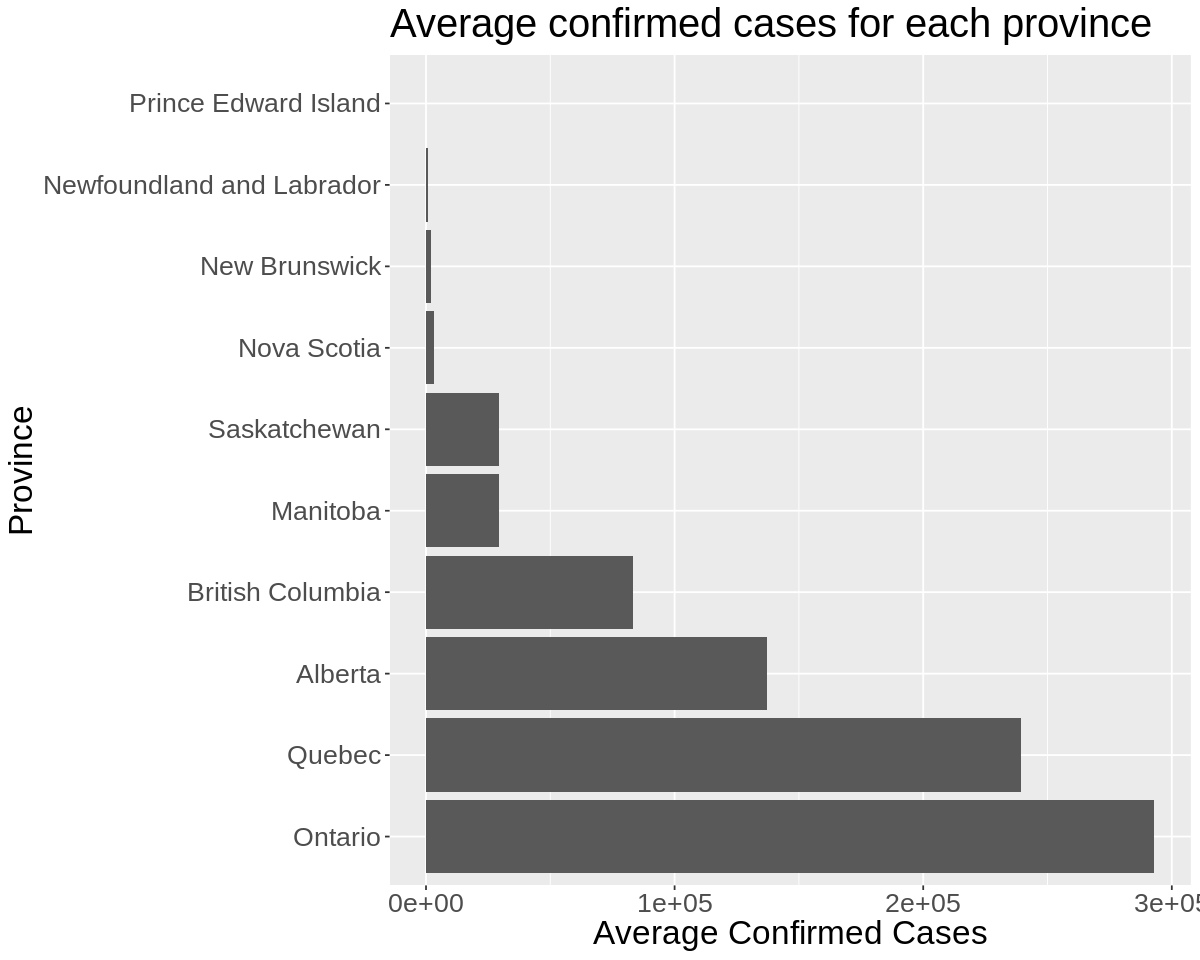

In [9]:
confirm_plot <- confirm_table |>
                     ggplot(aes(x = fct_reorder(province, mean_conf, .desc = TRUE), y = mean_conf)) +
                     geom_bar(stat = "identity")+
                     labs(x = "Province", y = "Average Confirmed Cases", fill = "Province")+
                     theme(text = element_text(size = 20))+
                      coord_flip()+
                     ggtitle("Average confirmed cases for each province")
confirm_plot

Figure 1: Exploratory visualization as described below.

As demonstrated in the above plot, we can see that the larger provinces (Ontario, Quebec, and Alberta) have a much higher average number of confirmed cases in relation to the smaller, maritime provinces (PEI, Newfoundland and Labarador, Newbruinswick, and Nova Scotia). By including the number of confirmed cases in our classification, our model will be able to accurately classify an unknown set of data.

### Methods

In order to predict labels and classes for observations with unknown class, we have to use a classification algorithm; one of which is called k-nearest neighbors algorithm. This method is based on finding the nearest observation data points and taking their majority vote as the predicted class for the new observation. There are powerful tools which enable us to train models which preform knn classification on large amount of data. A way to measure the accuracy of trained models is to find the root mean square percentage error (RMSPE).

For our data analysis, we split the COVID-19 data (dating from January 31, 2020, to December 17, 2021) into a testing and training set. Next, we use the number confirmed and percent recovered to train our data to predict which province the data is describing. 

As stated in the introduction, difference in provice/territory population means that the number of people who recover does not carry the same weight between provinces. Therefore, we use percent recovered to account for this variation.

In addition to the data of the total number of confirmed cases, there are other variables which are different for 10 provinces in Canada and we can use them as our classifiers. We choose to cover the percentage of recovery cases for our data analysis.

At the end of the project, we will visualize our results through a scatter plot, plotting the recovery rate against number of confirmed cases, then colouring the data points according to their province label.

### Data Analysis

Let's take a look at the training data again.

In [10]:
covid_train

province,numconf,percentrecover
<fct>,<dbl>,<dbl>
British Columbia,725,25.66
Manitoba,11,2.78
Ontario,858,0.93
Nova Scotia,73,2.74
Prince Edward Island,9,11.11
British Columbia,725,25.66
Alberta,542,4.98
⋮,⋮,⋮
Saskatchewan,82069,98.18


Table 7: Reloading of the training data.

We can use an scatterplot to get a rough idea of where our data points are and how they are labelled.

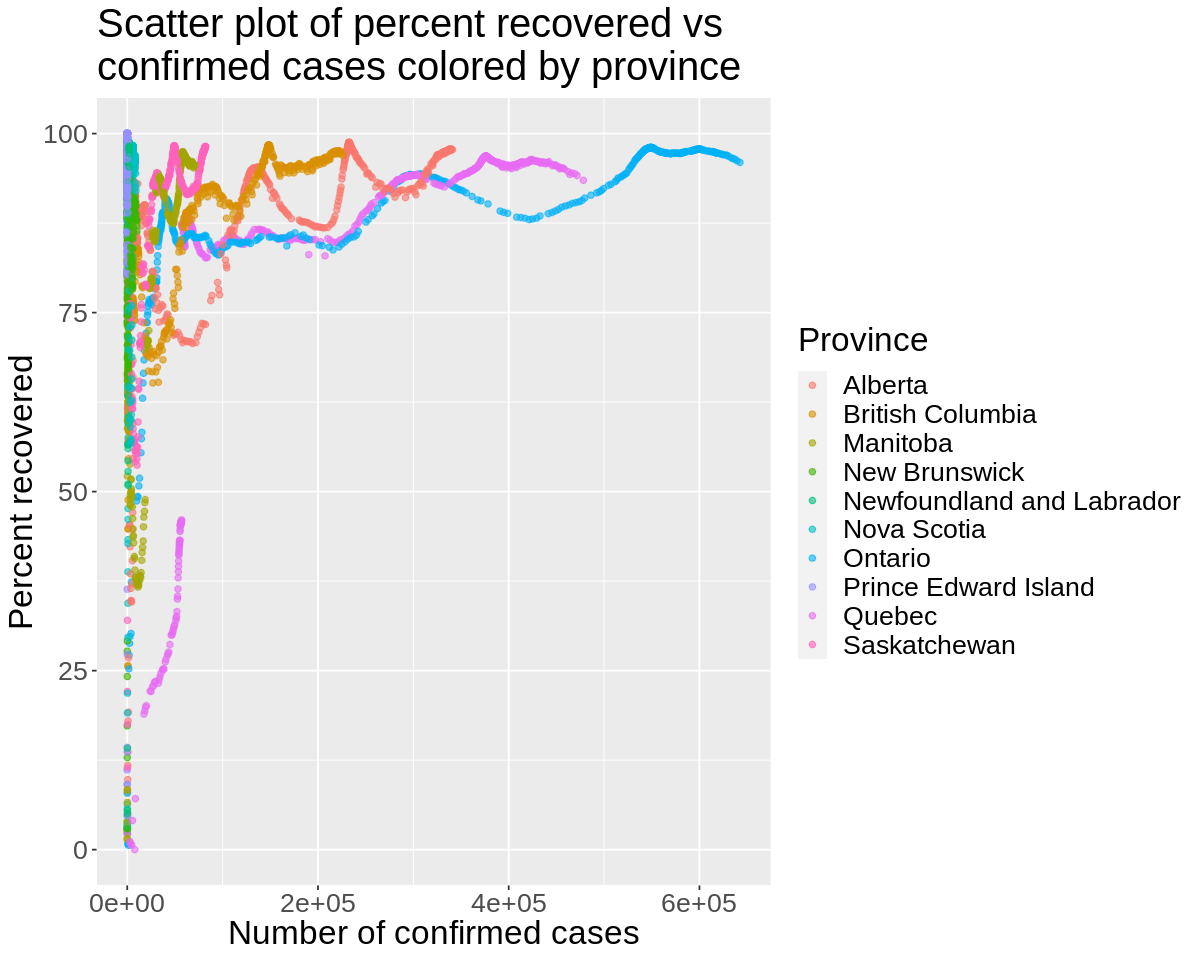

In [11]:
covid_train_plot <- covid_train |>
        ggplot(aes(x= numconf, y= percentrecover, color= province)) +
        geom_point(alpha= 0.6) +
        labs(x= "Number of confirmed cases", y= "Percent recovered", color= "Province") +
        ggtitle("Scatter plot of percent recovered vs \nconfirmed cases colored by province") +
        theme(text= element_text (size= 20))
covid_train_plot

Figure 2: A scatter plot to provide a visualization of the data.

In order to train our model with knn algorithm, we need a value for the number of neighbors that we choose to preform each prediction. The best way to find the suitable k value, is to preform cross validation.

In [12]:
set.seed(100)

# Preforming 5 fold cross validation to find the best value for k
covid_train_vfold <- vfold_cv(covid_train, v= 5, strata= province)

# Model specification
knn_spec <- nearest_neighbor(weight_func= "rectangular", neighbors= tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

# Recipe for setting province as target variable and all others as predictors;
# Standardize the predictors
covid_recipe <- recipe(province ~ ., data= covid_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

# Evaluate the model for 10 values of k
k_vals <- tibble(neighbors = seq(from = 2, to = 10, by = 1))

knn_fit <- workflow() |>
    add_recipe(covid_recipe) |>
    add_model(knn_spec) |>
    tune_grid(resamples= covid_train_vfold, grid= k_vals) |>
    collect_metrics() |>
    filter(.metric == "accuracy")
knn_fit

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
2,accuracy,multiclass,0.7864353,5,0.008962069,Preprocessor1_Model1
3,accuracy,multiclass,0.7610651,5,0.007096030,Preprocessor1_Model2
4,accuracy,multiclass,0.7531221,5,0.006511354,Preprocessor1_Model3
5,accuracy,multiclass,0.7385069,5,0.006124237,Preprocessor1_Model4
6,accuracy,multiclass,0.7324759,5,0.005871256,Preprocessor1_Model5
7,accuracy,multiclass,0.7156922,5,0.007435047,Preprocessor1_Model6
8,accuracy,multiclass,0.7113943,5,0.008719286,Preprocessor1_Model7
9,accuracy,multiclass,0.7075273,5,0.006329021,Preprocessor1_Model8
10,accuracy,multiclass,0.7068800,5,0.006247328,Preprocessor1_Model9


Table 8: Outlining and determining the ideal K value.

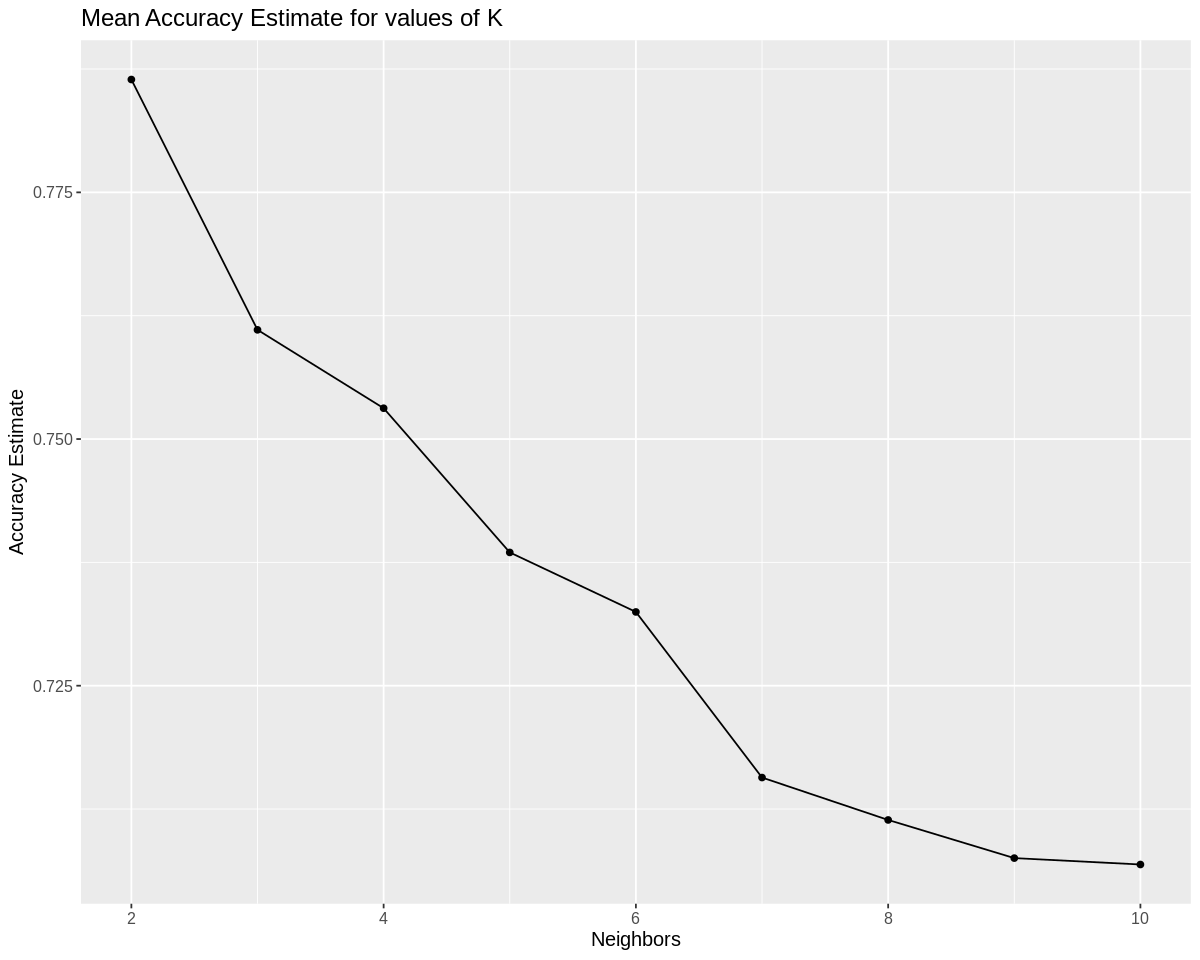

In [13]:
# Plot mean accuracies for values of k
accuracy_vs_k <- ggplot(knn_fit, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate") +
  ggtitle("Mean Accuracy Estimate for values of K") +
  theme(text = element_text(size = 12))

accuracy_vs_k

Figure 3: A visualization of the accuracies of different K values.

We have chosen k = 2 as our number of neighbours since our data is already in a "line plot". It makes sense that our model is more inaccurate with the more neighbours we choose (in previous assignments, we were analyzing data that was more scattered which is why the number of neighbours was larger). Also choosing k = 2 is not computationally taxing.

In [14]:
set.seed(100)

# Choosing the best k based on accuracy plot
best_k <- 2

# Model specification
covid_spec <- nearest_neighbor(weight_func= "rectangular", neighbors= best_k) |>
    set_engine("kknn") |>
    set_mode("classification")

# Combine model specification and recipe in a workflow and build the classifier
covid_fit <- workflow() |>
    add_recipe(covid_recipe) |>
    add_model(covid_spec) |>
    fit(data= covid_train)

# Predict province using test data
class_prediction <- covid_fit |>
    predict(covid_test) |>
    bind_cols(covid_test)
#class_prediction

# Compute the accuracy 
classifier_accuracy <- class_prediction |>
    metrics(truth= province, estimate= .pred_class) |>
    filter(.metric == "accuracy") |>
    select(.estimate)
#classifier_accuracy

# Confusion matrix
confusion_matrix <- class_prediction |>
    conf_mat(truth= province, estimate= .pred_class)
#confusion_matrix

In [15]:
class_prediction

.pred_class,province,numconf,percentrecover
<fct>,<fct>,<dbl>,<dbl>
Newfoundland and Labrador,Alberta,486,5.56
Nova Scotia,Saskatchewan,95,3.16
Ontario,Quebec,1629,0.12
New Brunswick,Saskatchewan,104,2.88
Manitoba,Quebec,2021,1.43
Nova Scotia,New Brunswick,45,2.22
Prince Edward Island,Prince Edward Island,11,9.09
⋮,⋮,⋮,⋮
British Columbia,British Columbia,224998,97.16


Table 9: Glance at the results of our model.

In [16]:
classifier_accuracy

.estimate
<dbl>
0.8032258


Table 10: A tibble presenting the accuracy of our model.

In [17]:
confusion_matrix

                           Truth
Prediction                  Alberta British Columbia Manitoba New Brunswick
  Alberta                       126                2        2             1
  British Columbia                7              125        3             3
  Manitoba                        3                3      107            13
  New Brunswick                   5                4        3           111
  Newfoundland and Labrador       1                0       12            20
  Nova Scotia                     1                1        2            10
  Ontario                         2                0        4             0
  Prince Edward Island            0                0        5            18
  Quebec                          2                0        0             0
  Saskatchewan                    2                5        6            12
                           Truth
Prediction                  Newfoundland and Labrador Nova Scotia Ontario
  Alberta               

Table 10: The confusion matrix for our model.

On average, our model was able to make true predictions more than 80 percent of the time. This shows that there are meaningful characteristics that differentiate each province health situation through Covid 19 pandemic.

### Discussion

Through our initial exploratory analysis, we found that Prince Edward Island had the highest average percent recovery rate while Quebec had the lowest. However, through our classification, we found that the model predicted that later in the pandemic, the Maritime provinces (New Bruinswick, PEI, Nova Scotia, and Newfoundland and Labrador) had lower recovery rates than the mainland provinces. This means that despite having an overall higher average recovery rate, these smaller provinces struggled later on in the pandemic.

This result is contradictory to what we believed would happen. PEI and the Maritime provinces had the highest overall recovery rate while the larger provinces lagged behind. These findings can indicate that the smaller, maritime provinces did well during the beginning or middle of the pandemic, but something occurred which brought their recovery rate down. Further analysis can be completed to determine what caused this change and how to best act during a pandemic so that recovery rates are maximized.

### Reference

1. Canada, P. H. A. of. (2020, May 31). Covid-19 epidemiology update. Canada.ca. Retrieved November 30, 2022, from https://health-infobase.canada.ca/covid-19/?redir=1#tiles 
This website is updated by everyday, but we just took the data from date of January 31st, 2020 to December 17th, 2021.

2. Centers for Disease Control and Prevention. (n.d.). Symptoms of COVID-19. Centers for Disease Control and Prevention. Retrieved November 30, 2022, from https://www.cdc.gov/coronavirus/2019-ncov/symptoms-testing/symptoms.html 
We know several symptoms of COVID-19.

3. Timbers, T., Campbell, T., &amp; Lee, M. (2022). Data Science a first introduction. CRC Press, Taylor &amp; Francis Group. 
Some code gets from our textbook.